In [1]:
import pandas
import time
import github
import gpt
import Score

In [2]:
def run_experiment(csvFile):
    for i in range(0, len(csvFile)):
        repo_identifier = csvFile.iloc[i]['GitHub_Repo_Link'].split('github.com/')[1]
        print(repo_identifier)
        try:
            default_branch = github.get_default_branch(repo_identifier);
            repo_structure = github.get_repository_tree(repo_identifier, default_branch)
            recursive_repo_structure = github.get_recursive_repository_tree(repo_identifier, default_branch)
            dependencies = github.get_list_of_dependencies(repo_identifier)
            build_file_content = csvFile.iloc[i]['GitHub_Build_Pipeline_File_Content']
            repo_language = csvFile.iloc[i]['Language']

            generated_workflow_file = gpt.generate_build_pipeline(repo_structure, dependencies, default_branch, recursive_repo_structure)

            csvFile.loc[i,'Generated_Build_Pipeline_File_Content'] = generated_workflow_file
            valid_syntax = github.run_action_lint(generated_workflow_file);
            if not valid_syntax:
                csvFile.loc[i,'Syntax_Check'] = 'Invalid'
                continue

            csvFile.loc[i,'Syntax_Check'] = 'Valid'
            
            exact_match_score = Score.get_exact_match_score(generated_workflow_file, build_file_content)
            bleu_score = Score.get_bleu_score(generated_workflow_file, build_file_content)
            devops_aware_score = Score.get_devops_aware_score(generated_workflow_file, build_file_content, repo_language)

            csvFile.loc[i,'Exact_Match_Score'] = exact_match_score
            csvFile.loc[i,'BLEU_Score'] = bleu_score
            csvFile.loc[i,'DevOps_Aware_Score'] = devops_aware_score
            # Add delay to avoid rate limiting
            #time.sleep(5)
        except Exception as e:
            print(e)
            continue

    csvFile.to_csv('dataset/output.csv', index=False)

In [5]:
# reading the CSV file
csvFile = pandas.read_csv('dataset/filtered_repos.csv')

# Pre-processing the CSV file
csvFile = csvFile[csvFile['GitHub_Repo_Link'].notna()]

# Explicitly specify dtypes to avoid pandas inferring dtypes
csvFile = csvFile.astype({'GitHub_Repo_Link': 'string', 'GitHub_Build_Pipeline_File_Content': 'string', 'Generated_Build_Pipeline_File_Content': 'string', 'Syntax_Check': 'string', 'Exact_Match_Score': 'float', 'BLEU_Score': 'float', 'DevOps_Aware_Score': 'float'})

csvFile

,Index,GitHub_Repo_Link,GitHub_Build_Pipeline_File_Content,Generated_Build_Pipeline_File_Content,Exact_Match_Score,BLEU_Score,Syntax_Check,DevOps_Aware_Score,Language
0,1,https://github.com/sparklemotion/nokogiri,"name: upstream concurrency: group: ""${{githu...",<NA>,NaN,NaN,<NA>,NaN,C
1,2,https://github.com/connectbot/connectbot,name: Continuous Integration on: push: ...,<NA>,NaN,NaN,<NA>,NaN,Java
2,3,https://github.com/bwaldvogel/liblinear-java,name: CI on: push: branches: [ main ] ...,<NA>,NaN,NaN,<NA>,NaN,Java
3,4,https://github.com/twitter4j/twitter4j,# This workflow will build a Java project with...,<NA>,NaN,NaN,<NA>,NaN,Java
4,5,https://github.com/rzwitserloot/lombok,name: Tests on: push: pull_request: jobs...,<NA>,NaN,NaN,<NA>,NaN,Java
...,...,...,...,...,...,...,...,...,...
2127,2128,https://github.com/hanskristian-work/vkd3d-proton,"name: Test Builds on Linux on: [push, pull_re...",<NA>,NaN,NaN,<NA>,NaN,C
2128,2129,https://github.com/cofyc/argparse,name: ci on: push: branches: - mast...,<NA>,NaN,NaN,<NA>,NaN,C
2129,2130,https://github.com/adafruit/adafruit_nrf52_ard...,"name: Build on: [pull_request, push] concurr...",<NA>,NaN,NaN,<NA>,NaN,C
2130,2131,https://github.com/godotexplorer/ecmascript,name: 🐧 Linux Builds on: workflow_call: ...,<NA>,NaN,NaN,<NA>,NaN,C


In [6]:
run_experiment(csvFile)

sparklemotion/nokogiri
Command '['actionlint', 'workflow.yml']' returned non-zero exit status 1.
workflow.yml:1:1: "on" section is missing in workflow [syntax-check]
  |
1 | name: Build and Test
  | ^~~~~
workflow.yml:1:1: "jobs" section is missing in workflow [syntax-check]
  |
1 | name: Build and Test
  | ^~~~~
connectbot/connectbot
bwaldvogel/liblinear-java
twitter4j/twitter4j
workflow.yml:18:Command '['actionlint', 'workflow.yml']' returned non-zero exit status 1.
rzwitserloot/lombok
13: missing input "distribution" which is required by action "actions/setup-java@v2". all required inputs are "distribution", "java-version" [action]
   |
18 |       uses: actions/setup-java@v2
   |             ^~~~~~~~~~~~~~~~~~~~~
workflow.ymlCommand '['actionlint', 'workflow.yml']' returned non-zero exit status 1.
apache/hive
:18:15: missing input "distribution" which is required by action "actions/setup-java@v2". all required inputs are "distribution", "java-version" [action]
   |
18 |         uses

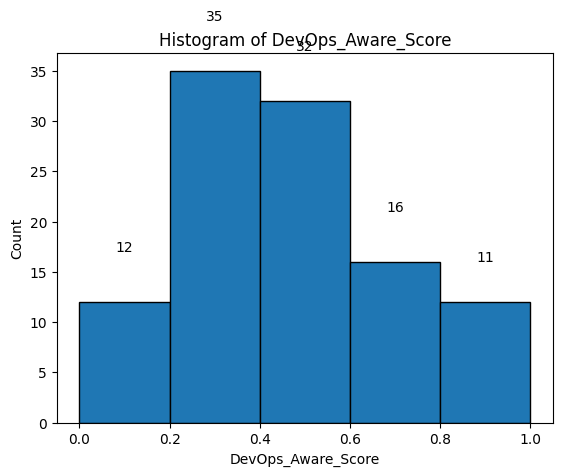

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# read the csv file
df = pd.read_csv('dataset/output.csv')

# filter out rows with empty DevOps_Aware_Score
df = df[df['DevOps_Aware_Score'].notna()]

# create histogram
plt.hist(df['DevOps_Aware_Score'], bins=5, range=(0, 1), edgecolor='black')

# set labels and title
plt.xlabel('DevOps_Aware_Score')
plt.ylabel('Count')
plt.title('Histogram of DevOps_Aware_Score')

# show count on top of each histogram
for i in range(5):
    count = len(df[(df['DevOps_Aware_Score'] >= i*0.2) & (df['DevOps_Aware_Score'] < (i+1)*0.2)])
    plt.text(i*0.2+0.1, count+5, str(count), ha='center')

# show the plot
plt.show()

/tmp/ipykernel_2201/3522334062.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = grouped_data.iloc[i][j]


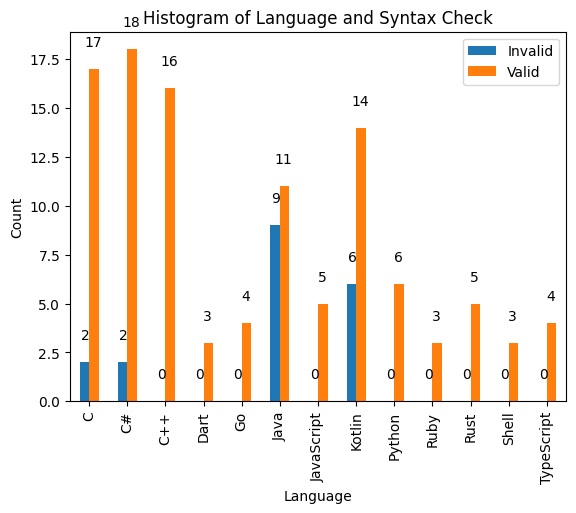

In [18]:
import pandas as pd
import matplotlib.pyplot as plt


# Read the CSV file
df = pd.read_csv('./dataset/output.csv')

# Group the data by language and syntax check
grouped_data = df.groupby(['Language', 'Syntax_Check']).size().unstack()

#plot histogram with multibar plot for each language and syntax check combination 
grouped_data.plot(kind='bar', stacked=False)

# add legend
plt.legend(loc='upper right')

#add count on top of each bar in histogram int only and if value is nan or infinities then replace it with 0

for i in range(len(grouped_data)):
    for j in range(2):
        count = grouped_data.iloc[i][j]
        if count == float('inf') or count == float('-inf') or count != count:
            count = 0
        plt.text(i + j * 0.2 - 0.1, count + 1, str(int(count)), ha='center', va='bottom')


# Set labels and title
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Histogram of Language and Syntax Check')

# Show the plot
plt.show()


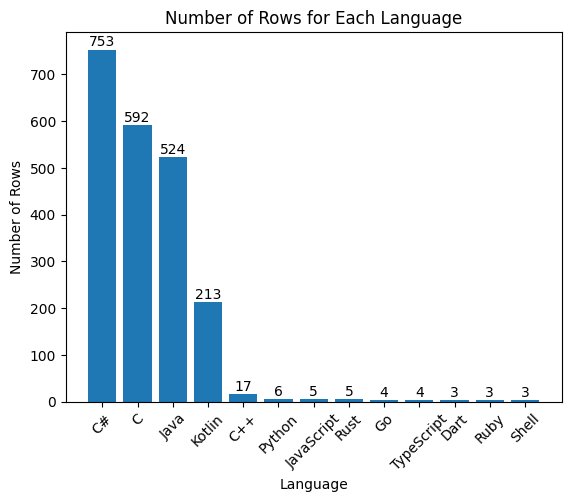

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('./dataset/filtered_repos.csv')

# Group the data by language
grouped_data = df.groupby('Language').size()

# Sort the data in descending order
grouped_data.sort_values(ascending=False, inplace=True)

#add count on top of each bar in histogram int only and if value is nan or infinities then replace it with 0
for i in range(len(grouped_data)):
    count = grouped_data.iloc[i]
    if count == float('inf') or count == float('-inf') or count != count:
        count = 0
    plt.text(i, count + 1, str(int(count)), ha='center', va='bottom')

# Plot the histogram
plt.bar(grouped_data.index, grouped_data.values)
plt.xlabel('Language')
plt.ylabel('Number of Rows')
plt.title('Number of Rows for Each Language')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


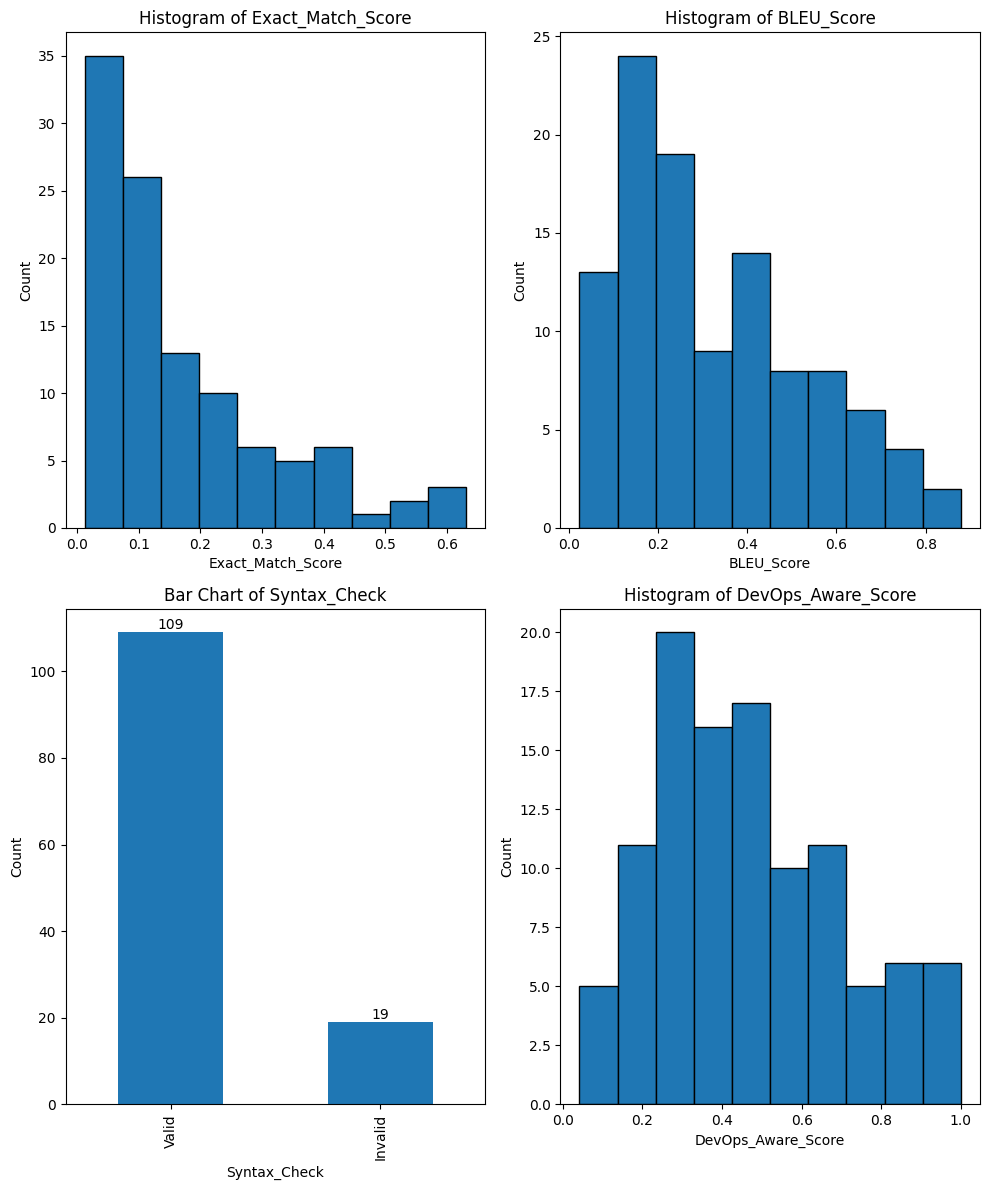

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('dataset/output.csv')

# Set a larger figure size
plt.figure(figsize=(10, 12))

# Plot histogram of Exact_Match_Score
plt.subplot(2, 2, 1)
plt.hist(df['Exact_Match_Score'], bins=10, edgecolor='black')
plt.xlabel('Exact_Match_Score')
plt.ylabel('Count')
plt.title('Histogram of Exact_Match_Score')


# Plot histogram of BLEU_Score
plt.subplot(2, 2, 2)
plt.hist(df['BLEU_Score'], bins=10, edgecolor='black')
plt.xlabel('BLEU_Score')
plt.ylabel('Count')
plt.title('Histogram of BLEU_Score')


# Plot bar chart of Syntax_Check
plt.subplot(2, 2, 3)
syntax_check_counts = df['Syntax_Check'].value_counts()
syntax_check_counts.plot(kind='bar')
plt.xlabel('Syntax_Check')
plt.ylabel('Count')
plt.title('Bar Chart of Syntax_Check')

# Add count on top of each bar
for i in range(len(syntax_check_counts)):
    count = syntax_check_counts.iloc[i]
    plt.text(i, count, str(count), ha='center', va='bottom')

# Plot histogram of DevOps_Aware_Score
plt.subplot(2, 2, 4)
plt.hist(df['DevOps_Aware_Score'], bins=10, edgecolor='black')
plt.xlabel('DevOps_Aware_Score')
plt.ylabel('Count')
plt.title('Histogram of DevOps_Aware_Score')



# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()
